In [1]:
import os
import warnings
import re
import random
import math
import pandas as pd
import numpy as np
import scipy
import sklearn

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [4]:
feeds_df = pd.read_csv(os.getcwd() + '/Datasets/feeds_df_for_reco.csv')
feeds_df['createdAt'] = pd.to_datetime(feeds_df['createdAt'])
feeds_df['updatedAt'] = pd.to_datetime(feeds_df['updatedAt'])
feeds_df = feeds_df[~feeds_df['text'].isna()]
print(feeds_df.shape)
feeds_df.head()

(1740, 13)


,contentId,anonymous,authorId,createdAt,isActive,isDelete,points,text,type,updatedAt,resource_link,resource_videoUrl,resource_image
0,5df454f37e4ea600161b8e2e,False,5df454297e4ea600161b8e25,2019-12-14 03:20:19.029,True,False,0.030534,Hi I am Shreshtha. I have been baking for the ...,QUESTION,2020-02-06 05:14:28.854,[],[],[]
1,5df4556a7e4ea600161b8e32,False,5df454297e4ea600161b8e25,2019-12-14 03:22:18.526,True,False,0.007634,My name is Shreshtha. I have often faced probl...,POST,2020-02-06 05:14:28.861,[],[],[]
2,5df4558d7e4ea600161b8e36,False,5df454297e4ea600161b8e25,2019-12-14 03:22:53.968,True,True,0.000000,I am STRESSED. My client has terminated our co...,QUESTION,2020-03-20 08:55:56.624,[],[],[]
3,5df456257e4ea600161b8e41,False,5df454d27e4ea600161b8e2a,2019-12-14 03:25:25.300,True,False,0.007634,Hello. I am Yashi. I have just started freelan...,POST,2020-02-06 05:14:28.872,[],[],[]
4,5df457077e4ea600161b8e53,False,5df4561e7e4ea600161b8e3e,2019-12-14 03:29:11.865,True,False,0.007634,"Hello, my name is Kalyani. I have done my bach...",QUESTION,2020-02-06 05:14:28.877,[],[],[]


# Interactions Data

In [5]:
likes_df = pd.read_csv(os.getcwd() + '/Datasets/likes_coll_df.csv')
likes_df['createdAt'] = pd.to_datetime(likes_df['createdAt'])
likes_df['updatedAt'] = pd.to_datetime(likes_df['updatedAt'])
likes_df = likes_df[likes_df['type'] != 'ARTICLE']
print(likes_df.shape)
likes_df.head()

(4456, 9)


,likeId,commentId,createdAt,emojiType,isActive,referenceId,type,updatedAt,userId
0,5df475d96c5e063edebdc43b,NaN,2019-12-14 05:40:41.806,Like,True,5df457ad7e4ea600161b8e6b,QUESTION,2019-12-14 05:40:41.806,5df45f167e4ea600161b8f7a
1,5df476086c5e063edebdc808,NaN,2019-12-14 05:41:28.112,Like,True,5df45ae07e4ea600161b8ed9,QUESTION,2019-12-14 05:41:28.112,5df462f87e4ea600161b9028
2,5df47d1f6c5e063edebe4b1f,NaN,2019-12-14 06:11:43.365,Like,True,5df465647e4ea600161b90bf,QUESTION,2019-12-14 06:11:43.365,5df462dd7e4ea600161b9020
3,5df480796c5e063edebe805d,5df466b77e4ea600161b90f5,2019-12-14 06:26:01.856,Like,True,NaN,COMMENT,2019-12-14 06:26:08.634,5df4579f7e4ea600161b8e68
4,5df48a2d6c5e063edebf2b2f,NaN,2019-12-14 07:07:25.472,Like,True,5df47dfc7e4ea600161b94af,POST,2019-12-14 07:07:25.472,5df468777e4ea600161b912c


In [6]:
comments_df = pd.read_csv(os.getcwd() + '/Datasets/comments_df.csv')
comments_df['createdAt'] = pd.to_datetime(comments_df['createdAt'])
print(comments_df.shape)
comments_df.head()

(4426, 8)


,commentId,authorId,createdAt,isActive,isSubComment,referenceId,type,comment_text
0,5df465a37e4ea600161b90cc,5df454d27e4ea600161b8e2a,2019-12-14 04:31:31.673,True,False,5df462557e4ea600161b9005,QUESTION,Hi Sonali! I completely relate to you. When I ...
1,5df4669a7e4ea600161b90ee,5df45ccb7e4ea600161b8f0c,2019-12-14 04:35:38.644,True,False,5df456257e4ea600161b8e41,POST,"Hi Yashi. Everyone starts from scratch, so do ..."
2,5df466b77e4ea600161b90f5,5df45ccb7e4ea600161b8f0c,2019-12-14 04:36:07.134,True,False,5df458dd7e4ea600161b8e8f,POST,Hi. Digital marketing is a booming industry an...
3,5df46e3a7e4ea600161b91cc,5df45b5b7e4ea600161b8ede,2019-12-14 05:08:10.793,True,False,5df46de57e4ea600161b91c5,QUESTION,Hi. Digital marketing is a booming industry an...
4,5df46fec7e4ea600161b9271,5df454297e4ea600161b8e25,2019-12-14 05:15:24.995,True,False,5df463a77e4ea600161b9055,QUESTION,Hi Shikha. Being someone who has started using...


In [7]:
bookmarks_df = pd.read_csv(os.getcwd() + '/Datasets/bookmarks_coll_df.csv')
bookmarks_df['createdAt'] = pd.to_datetime(bookmarks_df['createdAt'])
bookmarks_df['updatedAt'] = pd.to_datetime(bookmarks_df['updatedAt'])
bookmarks_df = bookmarks_df[bookmarks_df['type'] != 'COMPANY']
print(bookmarks_df.shape)
bookmarks_df.head()

(126, 7)


,bookmarkId,createdAt,isActive,referenceFeedId,type,updatedAt,userId
0,5e5e1649038098664944898f,2020-03-03 08:33:13.597,True,5e579f2ac9509a00163d6376,POST,2020-03-03 08:33:13.597,5df45b5b7e4ea600161b8ede
1,5e5e1df0038098664944f081,2020-03-03 09:05:52.348,True,5e5e195568860c00163d49db,POST,2020-03-16 09:37:54.993,5df4c077a68eb700165a66c3
2,5e5e1edb038098664945066f,2020-03-03 09:09:47.666,False,5e5dd35d9e8fd60016a2d25d,POST,2020-03-03 09:16:20.910,5df4c077a68eb700165a66c3
3,5e5e1f380380986649450f80,2020-03-03 09:11:20.238,False,5e5dcd039e8fd60016a2d245,POST,2020-03-03 09:16:25.381,5df4c077a68eb700165a66c3
6,5e5f560c012af91a30097e65,2020-03-04 07:17:32.122,True,5e5e195568860c00163d49db,POST,2020-03-04 07:17:32.122,5df45b5b7e4ea600161b8ede


In [8]:
likes_df.columns

Index(['likeId', 'commentId', 'createdAt', 'emojiType', 'isActive',
       'referenceId', 'type', 'updatedAt', 'userId'],
      dtype='object')

In [9]:
comments_df.columns

Index(['commentId', 'authorId', 'createdAt', 'isActive', 'isSubComment',
       'referenceId', 'type', 'comment_text'],
      dtype='object')

In [10]:
bookmarks_df.columns

Index(['bookmarkId', 'createdAt', 'isActive', 'referenceFeedId', 'type',
       'updatedAt', 'userId'],
      dtype='object')

In [11]:
post_likes_df = likes_df[likes_df['type'] != 'COMMENT']
print(post_likes_df.shape)
post_likes_df = post_likes_df[['likeId', 'referenceId', 'userId', 'createdAt', 'type']]
post_likes_df = post_likes_df.rename(columns = {'likeId':'eventId', 'referenceId':'contentId', 'userId':'personId'})
post_likes_df['eventType'] = 'LIKE'

(2490, 9)


In [12]:
likes_df_formatted = post_likes_df
likes_df_formatted.head()

,eventId,contentId,personId,createdAt,type,eventType
0,5df475d96c5e063edebdc43b,5df457ad7e4ea600161b8e6b,5df45f167e4ea600161b8f7a,2019-12-14 05:40:41.806,QUESTION,LIKE
1,5df476086c5e063edebdc808,5df45ae07e4ea600161b8ed9,5df462f87e4ea600161b9028,2019-12-14 05:41:28.112,QUESTION,LIKE
2,5df47d1f6c5e063edebe4b1f,5df465647e4ea600161b90bf,5df462dd7e4ea600161b9020,2019-12-14 06:11:43.365,QUESTION,LIKE
4,5df48a2d6c5e063edebf2b2f,5df47dfc7e4ea600161b94af,5df468777e4ea600161b912c,2019-12-14 07:07:25.472,POST,LIKE
7,5df502636c5e063edec634c2,5df4b02ea68eb700165a6645,5df45b5b7e4ea600161b8ede,2019-12-14 15:40:19.326,QUESTION,LIKE


In [13]:
comments_df_formatted = comments_df[['commentId', 'referenceId', 'authorId', 'createdAt', 'type', 'isSubComment']]
comments_df_formatted = comments_df_formatted.rename(columns = {'commentId':'eventId', 'referenceId':'contentId', 'authorId':'personId'})
comments_df_formatted['eventType'] = np.where(comments_df_formatted['isSubComment'] == False, 'COMMENT', 'SUBCOMMENT')
comments_df_formatted = comments_df_formatted.drop(['isSubComment'], axis=1)
comments_df_formatted.head()


,eventId,contentId,personId,createdAt,type,eventType
0,5df465a37e4ea600161b90cc,5df462557e4ea600161b9005,5df454d27e4ea600161b8e2a,2019-12-14 04:31:31.673,QUESTION,COMMENT
1,5df4669a7e4ea600161b90ee,5df456257e4ea600161b8e41,5df45ccb7e4ea600161b8f0c,2019-12-14 04:35:38.644,POST,COMMENT
2,5df466b77e4ea600161b90f5,5df458dd7e4ea600161b8e8f,5df45ccb7e4ea600161b8f0c,2019-12-14 04:36:07.134,POST,COMMENT
3,5df46e3a7e4ea600161b91cc,5df46de57e4ea600161b91c5,5df45b5b7e4ea600161b8ede,2019-12-14 05:08:10.793,QUESTION,COMMENT
4,5df46fec7e4ea600161b9271,5df463a77e4ea600161b9055,5df454297e4ea600161b8e25,2019-12-14 05:15:24.995,QUESTION,COMMENT


In [14]:
bookmarks_df_formatted = bookmarks_df[['bookmarkId', 'referenceFeedId', 'userId', 'createdAt', 'type']]
bookmarks_df_formatted = bookmarks_df_formatted.rename(columns = {'bookmarkId':'eventId', 'referenceFeedId':'contentId', 'userId':'personId'})
bookmarks_df_formatted['eventType'] = 'BOOKMARK'
bookmarks_df_formatted.head()

,eventId,contentId,personId,createdAt,type,eventType
0,5e5e1649038098664944898f,5e579f2ac9509a00163d6376,5df45b5b7e4ea600161b8ede,2020-03-03 08:33:13.597,POST,BOOKMARK
1,5e5e1df0038098664944f081,5e5e195568860c00163d49db,5df4c077a68eb700165a66c3,2020-03-03 09:05:52.348,POST,BOOKMARK
2,5e5e1edb038098664945066f,5e5dd35d9e8fd60016a2d25d,5df4c077a68eb700165a66c3,2020-03-03 09:09:47.666,POST,BOOKMARK
3,5e5e1f380380986649450f80,5e5dcd039e8fd60016a2d245,5df4c077a68eb700165a66c3,2020-03-03 09:11:20.238,POST,BOOKMARK
6,5e5f560c012af91a30097e65,5e5e195568860c00163d49db,5df45b5b7e4ea600161b8ede,2020-03-04 07:17:32.122,POST,BOOKMARK


In [15]:
interactions_df = likes_df_formatted.append([comments_df_formatted, bookmarks_df_formatted])
print(interactions_df.shape)
interactions_df.head()

(7042, 6)


,eventId,contentId,personId,createdAt,type,eventType
0,5df475d96c5e063edebdc43b,5df457ad7e4ea600161b8e6b,5df45f167e4ea600161b8f7a,2019-12-14 05:40:41.806,QUESTION,LIKE
1,5df476086c5e063edebdc808,5df45ae07e4ea600161b8ed9,5df462f87e4ea600161b9028,2019-12-14 05:41:28.112,QUESTION,LIKE
2,5df47d1f6c5e063edebe4b1f,5df465647e4ea600161b90bf,5df462dd7e4ea600161b9020,2019-12-14 06:11:43.365,QUESTION,LIKE
4,5df48a2d6c5e063edebf2b2f,5df47dfc7e4ea600161b94af,5df468777e4ea600161b912c,2019-12-14 07:07:25.472,POST,LIKE
7,5df502636c5e063edec634c2,5df4b02ea68eb700165a6645,5df45b5b7e4ea600161b8ede,2019-12-14 15:40:19.326,QUESTION,LIKE


In [16]:
interaction_summary = interactions_df.groupby(['personId'])['contentId'].nunique().reset_index()
interaction_summary.columns = ['personId', 'content_ct']
interaction_summary = interaction_summary.sort_values(['content_ct'], ascending=False)
print("Total Users:", interaction_summary.shape)
print("Users with more than 1 content interaction:", interaction_summary[interaction_summary['content_ct']>1].shape)
interaction_summary.head()


Total Users: (1044, 2)
Users with more than 1 content interaction: (470, 2)


,personId,content_ct
97,5df4c077a68eb700165a66c3,164
100,5df72831d092c70016203a8e,155
226,5e783e20ea7e44002251594b,152
134,5df7877d11788b0016813430,136
113,5df734e4d092c70016203ba9,125


# Data Wrangling

In [17]:
event_type_strength = {
#   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
#   'FOLLOW': 3.0,
   'COMMENT': 4.0,
    'SUBCOMMENT': 4.0
}

interactions_df['eventStrength'] = interactions_df['eventType'].apply(lambda x: event_type_strength[x])

In [18]:
users_interactions_count_df = interactions_df.groupby(['personId', 'contentId']).size().groupby('personId').size()
print('# users: %d' % len(users_interactions_count_df))
users_with_1_interactions_df = users_interactions_count_df[users_interactions_count_df == 1].reset_index()[['personId']]
print('# users with 1 interactions: %d' % len(users_with_1_interactions_df))
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 2].reset_index()[['personId']]
print('# users with at least 2 interactions: %d' % len(users_with_enough_interactions_df))

# users: 1044
# users with 1 interactions: 574
# users with at least 2 interactions: 470


In [19]:
print('# of interactions: %d' % len(interactions_df))
interactions_from_selected_users_df = interactions_df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('# of interactions from users with at least 2 interactions: %d' % len(interactions_from_selected_users_df))

# of interactions: 7042
# of interactions from users with at least 2 interactions: 6252


In [20]:
print('# of interactions: %d' % len(interactions_df))
interactions_from_single_inter_users_df = interactions_df.merge(users_with_1_interactions_df, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('# of interactions from users with 1 interaction: %d' % len(interactions_from_single_inter_users_df))

# of interactions: 7042
# of interactions from users with 1 interaction: 790


In [21]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['personId', 'contentId'])['eventStrength'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head(10)

# of unique user/item interactions: 4851


,personId,contentId,eventStrength
0,5df38de0b2694d0016bdb71f,5df729fad092c70016203aae,1.584963
1,5df38de0b2694d0016bdb71f,5dfaf290f1289d0016d35420,1.584963
2,5df38de0b2694d0016bdb71f,5dfb23eef1289d0016d3559a,2.321928
3,5df38de0b2694d0016bdb71f,5dff09678a0466001664edf5,2.321928
4,5df38de0b2694d0016bdb71f,5e07659bfefbd10016d14987,1.584963
5,5df38de0b2694d0016bdb71f,5e08eb70a860560016a0a7aa,1.584963
6,5df38de0b2694d0016bdb71f,5e0d8b7e81cfd900167be187,1.584963
7,5df38de0b2694d0016bdb71f,5e1970f7bdaf6900167e1c16,2.321928
8,5df38de0b2694d0016bdb71f,5e1bf12282331f00165573ce,1.584963
9,5df38de0b2694d0016bdb71f,5e1cac5a4c69540016f084c9,2.321928


In [22]:
interactions_single_df = interactions_from_single_inter_users_df \
                    .groupby(['personId', 'contentId'])['eventStrength'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_single_df))
interactions_single_df.head(10)

# of unique user/item interactions: 574


,personId,contentId,eventStrength
0,5df454d27e4ea600161b8e2a,5df462557e4ea600161b9005,2.321928
1,5df458847e4ea600161b8e7e,5df462ba7e4ea600161b9016,2.321928
2,5df45a987e4ea600161b8ec4,5e82c672459bed0028b63983,2.321928
3,5df461787e4ea600161b8fea,5e8ef9b4e20eb6004601ccc1,2.807355
4,5df462697e4ea600161b9009,5df469d97e4ea600161b9149,2.321928
5,5df462f87e4ea600161b9028,5df45ae07e4ea600161b8ed9,2.807355
6,5df4633f7e4ea600161b903a,5df45f997e4ea600161b8f94,2.321928
7,5df464057e4ea600161b9060,5df45d8f7e4ea600161b8f25,2.321928
8,5df4651e7e4ea600161b9099,5df465017e4ea600161b9091,2.321928
9,5df467827e4ea600161b9113,5df4653f7e4ea600161b90a5,2.321928


In [23]:
full_interaction_df = interactions_full_df.append(interactions_single_df)
full_interaction_df.head()

,personId,contentId,eventStrength
0,5df38de0b2694d0016bdb71f,5df729fad092c70016203aae,1.584963
1,5df38de0b2694d0016bdb71f,5dfaf290f1289d0016d35420,1.584963
2,5df38de0b2694d0016bdb71f,5dfb23eef1289d0016d3559a,2.321928
3,5df38de0b2694d0016bdb71f,5dff09678a0466001664edf5,2.321928
4,5df38de0b2694d0016bdb71f,5e07659bfefbd10016d14987,1.584963


# Evaluation

In [24]:
interactions_multi_train_df, interactions_multi_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['personId'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Multi Train set: %d' % len(interactions_multi_train_df))
print('# interactions on Multi Test set: %d' % len(interactions_multi_test_df))

interactions_single_train_df, interactions_single_test_df = train_test_split(interactions_single_df,
                                   #stratify=interactions_full_df['personId'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Multi Train set: %d' % len(interactions_single_train_df))
print('# interactions on Multi Test set: %d' % len(interactions_single_test_df))

# interactions on Multi Train set: 3880
# interactions on Multi Test set: 971
# interactions on Multi Train set: 459
# interactions on Multi Test set: 115


In [25]:
interactions_train_df = interactions_multi_train_df.append(interactions_single_train_df)
interactions_test_df = interactions_multi_test_df.append(interactions_single_test_df)

In [26]:
#Indexing by personId to speed up the searches during evaluation
#interactions_full_indexed_df = interactions_full_df.set_index('personId')
#interactions_train_indexed_df = interactions_train_df.set_index('personId')
#interactions_test_indexed_df = interactions_test_df.set_index('personId')

In [27]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = full_interaction_df.set_index('personId')
interactions_train_indexed_df = interactions_train_df.set_index('personId')
interactions_test_indexed_df = interactions_test_df.set_index('personId')
interactions_single_train_indexed_df = interactions_single_train_df.set_index('personId')
interactions_single_test_indexed_df = interactions_single_test_df.set_index('personId')

In [28]:
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

In [29]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the movie information.
    if(((pd.Series(person_id).isin(pd.Series(interactions_df.index.unique().to_list()))) == True)[0]):
        interacted_items = interactions_df.loc[person_id]['contentId']
        return(set(interacted_items if type(interacted_items) == pd.Series else [interacted_items]))
    else:
        interacted_items = set()
        return(interacted_items)
    

In [30]:
def get_not_interacted_items_sample(person_id, sample_size, seed=42):
    interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
    all_items = set(feeds_df['contentId'])
    non_interacted_items = all_items - interacted_items

    random.seed(seed)
    non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
    return set(non_interacted_items_sample)

In [31]:
def _verify_hit_top_n(item_id, recommended_items, topn):
    try:
        index = next(i for i, c in enumerate(recommended_items) if c == item_id)
    except:
        index = -1
    hit = int(index in range(0, topn))
    return hit, index

In [52]:
def evaluate_model_for_user(model, person_id):
    #Getting the items in test set
    interacted_values_testset = interactions_test_indexed_df.loc[person_id]
    if type(interacted_values_testset['contentId']) == pd.Series:
        person_interacted_items_testset = set(interacted_values_testset['contentId'])
    else:
        person_interacted_items_testset = set([interacted_values_testset['contentId']])  
    interacted_items_count_testset = len(person_interacted_items_testset) 
    
    #Getting a ranked recommendation list from a model for a given user
    person_recs_df = model.recommend_items(person_id, 
                                         items_to_ignore=get_items_interacted(person_id, 
                                         interactions_train_indexed_df), 
                                         topn=100)
    hits_at_5_count = 0
    hits_at_10_count = 0
    #For each item the user has interacted in test set
    for item_id in person_interacted_items_testset:
        #Getting a random sample (100) items the user has not interacted 
        #(to represent items that are assumed to be no relevant to the user)
        non_interacted_items_sample = get_not_interacted_items_sample(person_id, 
                                                      sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                      seed=int(re.sub(r'[a-zA-Z]', r'', item_id))%(2**32))

        #Combining the current interacted item with the 100 random items
        items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

        #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
        valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]                    
        valid_recs = valid_recs_df['contentId'].values
        
        #Verifying if the current interacted item is among the Top-N recommended items
        hit_at_5, index_at_5 = _verify_hit_top_n(item_id, valid_recs, 5)
        hits_at_5_count += hit_at_5
        hit_at_10, index_at_10 = _verify_hit_top_n(item_id, valid_recs, 10)
        hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
    recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
    recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

    person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10,
                          'model_name': model.get_model_name()}
    return person_metrics, person_recs_df[0:10]

In [111]:
def evaluate_model(model, pop_model):
    #print('Running evaluation for users')
    people_metrics = []
    reco_list = pd.DataFrame(columns = ['contentId', 'eventStrength'])
    
    for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
        #if idx % 100 == 0 and idx > 0:
        #    print('%d users processed' % idx)
        #print(person_id)
        if(pd.Series(person_id).isin(interactions_single_test_indexed_df.index)[0] == True):
            person_metrics, rec_list = evaluate_model_for_user(pop_model, person_id)  
        else:
            person_metrics, rec_list = evaluate_model_for_user(model, person_id)
        person_metrics['_person_id'] = person_id
        people_metrics.append(person_metrics)
        reco_list = reco_list.append(rec_list)
        
    print('%d users processed' % idx)

    detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
    global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
    global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
    global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}
    
    
    return global_metrics, detailed_results_df, reco_list

# Popularity Model

In [112]:
#Computes the most popular items
#item_popularity_df = interactions_full_df.groupby('contentId')['eventStrength'].sum().sort_values(ascending=False).reset_index()
#item_popularity_df.head(10)

In [113]:
#For popularity use the entire set consisting of single interaction data as well as multiple interaction
full_interaction_df = interactions_full_df.append(interactions_single_df)
full_interaction_df.head()
#Computes the most popular items
item_popularity_df = full_interaction_df.groupby('contentId')['eventStrength'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head(10)

,contentId,eventStrength
0,5e782cd3ea7e440022515910,116.947231
1,5e95945b41a162004c575518,49.514339
2,5e959fed68c48d00292beb2a,47.994048
3,5e7ee7998735d5002991de15,46.783844
4,5e958b00bdca200024b49ecb,46.034690
5,5e05965154f7880016b75a5f,43.858499
6,5e8af4803b769d0037b551c3,41.876591
7,5e41010a1022e000161eb0ac,39.413825
8,5e8bf8a3dfb971004c66c8fd,37.468855
9,5df729fad092c70016203aae,36.030329


In [114]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['contentId'].isin(items_to_ignore)] \
                               .sort_values('eventStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['eventStrength', 'contentId']]


        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, feeds_df)

In [115]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df, full_reco_list = evaluate_model(popularity_model, popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model...
432 users processed

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.027624309392265192, 'recall@10': 0.049723756906077346}


,_person_id,hits@10_count,hits@5_count,interacted_count,model_name,recall@10,recall@5
8,5df4c077a68eb700165a66c3,2,0,33,Popularity,0.060606,0.000000
21,5df72831d092c70016203a8e,2,1,31,Popularity,0.064516,0.032258
16,5e783e20ea7e44002251594b,0,0,31,Popularity,0.000000,0.000000
121,5df7877d11788b0016813430,0,0,27,Popularity,0.000000,0.000000
2,5df734e4d092c70016203ba9,1,1,25,Popularity,0.040000,0.040000
5,5df38de0b2694d0016bdb71f,1,0,23,Popularity,0.043478,0.000000
3,5df72acdd092c70016203ac5,2,1,22,Popularity,0.090909,0.045455
0,5df73975d092c70016203c1f,0,0,20,Popularity,0.000000,0.000000
40,5e7d8ae72b1c620022131ee5,2,1,19,Popularity,0.105263,0.052632
34,5df76af011788b0016813414,3,1,19,Popularity,0.157895,0.052632


In [116]:
print("Coverage:", full_reco_list['contentId'].nunique() / feeds_df['contentId'].nunique())

Coverage: 0.008620689655172414


# Content-Based Filtering model

In [117]:
#Ignoring stopwords (words with no semantics) from English and Portuguese (as we have a corpus with mixed languages)
stopwords_list = stopwords.words('english')

#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = feeds_df['contentId'].tolist()
tfidf_matrix = vectorizer.fit_transform(feeds_df['text'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<1740x1588 sparse matrix of type '<class 'numpy.float64'>'
	with 33756 stored elements in Compressed Sparse Row format>

In [118]:
def get_item_profile(item_id):
    #print(item_id)
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    #print(ids)
    if(isinstance(ids, str)):
        ids = [ids]
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    #print(person_id)
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['contentId'])
    
    user_item_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = interactions_train_df[interactions_train_df['contentId'] \
                                                   .isin(feeds_df['contentId'])].set_index('personId')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        #print(person_id)
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [119]:
user_profiles = build_users_profiles()
len(user_profiles)

928

In [120]:
myprofile = user_profiles['5df4c077a68eb700165a66c3']
print(myprofile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles['5df4c077a68eb700165a66c3'].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

(1, 1588)


,token,relevance
0,kool,0.192764
1,hi,0.166050
2,community,0.138964
3,looking,0.138779
4,kool kanya,0.130375
5,kanya,0.128364
6,everyone,0.120969
7,work,0.119153
8,help,0.117988
9,would,0.117959


In [121]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['contentId', 'recStrength']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId']]


        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(feeds_df)

In [122]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [123]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df, full_reco_list = evaluate_model(content_based_recommender_model, popularity_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...
432 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.03683241252302026, 'recall@10': 0.05064456721915286}


,_person_id,hits@10_count,hits@5_count,interacted_count,model_name,recall@10,recall@5
8,5df4c077a68eb700165a66c3,3,1,33,Content-Based,0.090909,0.030303
21,5df72831d092c70016203a8e,0,0,31,Content-Based,0.000000,0.000000
16,5e783e20ea7e44002251594b,0,0,31,Content-Based,0.000000,0.000000
121,5df7877d11788b0016813430,0,0,27,Content-Based,0.000000,0.000000
2,5df734e4d092c70016203ba9,1,1,25,Content-Based,0.040000,0.040000
5,5df38de0b2694d0016bdb71f,2,2,23,Content-Based,0.086957,0.086957
3,5df72acdd092c70016203ac5,1,1,22,Content-Based,0.045455,0.045455
0,5df73975d092c70016203c1f,1,0,20,Content-Based,0.050000,0.000000
40,5e7d8ae72b1c620022131ee5,0,0,19,Content-Based,0.000000,0.000000
34,5df76af011788b0016813414,0,0,19,Content-Based,0.000000,0.000000


In [124]:
temp = cb_detailed_results_df[cb_detailed_results_df['model_name'] != 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")

temp = cb_detailed_results_df[cb_detailed_results_df['model_name'] == 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")

0.046343975283213185 for  318  Users
0.08695652173913043 for  115  Users


In [125]:
print("Coverage:", full_reco_list['contentId'].nunique() / feeds_df['contentId'].nunique())

Coverage: 0.5925287356321839


# Collaborative Filtering model

### Matrix Factorization

In [126]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='personId', 
                                                          columns='contentId', 
                                                          values='eventStrength').fillna(0)

users_items_pivot_matrix_df.head(10)

contentId,5df454f37e4ea600161b8e2e,5df4556a7e4ea600161b8e32,5df456257e4ea600161b8e41,5df457077e4ea600161b8e53,5df457ad7e4ea600161b8e6b,5df458dd7e4ea600161b8e8f,5df459cf7e4ea600161b8eaa,5df45ae07e4ea600161b8ed9,5df45d8f7e4ea600161b8f25,5df45e697e4ea600161b8f5e,...,5ea08b2d205648002e753b31,5ea08efefc66110044584c33,5ea0961f287ece004c6f796f,5ea0be43fc66110044584c4d,5ea0f8fab014c600468f0313,5ea0faa7fc66110044584c5c,5ea0fde52f48b50022416eac,5ea1060ff7979700323dec1a,5ea10b6b205648002e753b52,5ea1130cb014c600468f032b
personId,,,,,,,,,,,,,,,,,,,,,
5df38de0b2694d0016bdb71f,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5df431157e4ea600161b8e13,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5df454297e4ea600161b8e25,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5df454d27e4ea600161b8e2a,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5df4561e7e4ea600161b8e3e,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5df456267e4ea600161b8e43,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5df456497e4ea600161b8e49,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5df457557e4ea600161b8e5c,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5df4577c7e4ea600161b8e60,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [127]:
users_items_pivot_matrix_df.shape

(929, 1221)

In [128]:
users_items_pivot_matrix = users_items_pivot_matrix_df.as_matrix()
users_items_pivot_matrix[:10]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.32192809, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [129]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

['5df38de0b2694d0016bdb71f',
 '5df431157e4ea600161b8e13',
 '5df454297e4ea600161b8e25',
 '5df454d27e4ea600161b8e2a',
 '5df4561e7e4ea600161b8e3e',
 '5df456267e4ea600161b8e43',
 '5df456497e4ea600161b8e49',
 '5df457557e4ea600161b8e5c',
 '5df4577c7e4ea600161b8e60',
 '5df4579f7e4ea600161b8e68']

In [130]:
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix)
users_items_pivot_sparse_matrix

<929x1221 sparse matrix of type '<class 'numpy.float64'>'
	with 4339 stored elements in Compressed Sparse Row format>

In [131]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
#U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)

In [132]:
U.shape

(929, 15)

In [133]:
Vt.shape

(15, 1221)

In [134]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [135]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
print(all_user_predicted_ratings.shape)
all_user_predicted_ratings

(929, 1221)


array([[ 1.42579927e-01, -9.79916981e-02,  4.53983772e-02, ...,
         4.41148229e-04, -2.98192190e-03,  5.88926525e-02],
       [ 1.84400053e-03, -1.55670270e-04, -6.45085047e-04, ...,
        -3.41328634e-04, -1.29711210e-04,  1.41142188e-02],
       [ 4.52124283e-03,  6.61023628e-03,  3.11576111e-04, ...,
         2.78115990e-05,  2.41646958e-04,  9.81088049e-03],
       ...,
       [-8.28182200e-05, -4.19403346e-04,  8.49792094e-05, ...,
         1.19251009e-05,  1.79291572e-05,  8.71526808e-03],
       [ 9.14791719e-06, -1.25843235e-03,  1.77306033e-04, ...,
         2.57629577e-05,  4.34813342e-05,  2.50674780e-02],
       [ 2.14758410e-03,  2.16488740e-03,  5.07159612e-04, ...,
         3.28423591e-04,  3.67514366e-04,  2.16109036e-03]])

In [136]:
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

In [137]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,5df38de0b2694d0016bdb71f,5df431157e4ea600161b8e13,5df454297e4ea600161b8e25,5df454d27e4ea600161b8e2a,5df4561e7e4ea600161b8e3e,5df456267e4ea600161b8e43,5df456497e4ea600161b8e49,5df457557e4ea600161b8e5c,5df4577c7e4ea600161b8e60,5df4579f7e4ea600161b8e68,...,5ea0790f287ece004c6f7951,5ea07bf7fc66110044584bff,5ea07dc9f7979700323debe0,5ea0bc832f48b50022416eaa,5ea0f733b291720028246436,5ea0fae1205648002e753b4a,5ea102c75738810038814f8d,5ea106b6fc66110044584c77,5ea1228e5738810038814f9f,5ea125ebfc66110044584ca3
contentId,,,,,,,,,,,,,,,,,,,,,
5df454f37e4ea600161b8e2e,0.222280,0.201826,0.202215,0.201746,0.207785,0.202456,0.201558,0.201287,0.201622,0.210418,...,0.201554,0.201512,0.201536,0.201384,0.202058,0.201875,0.201764,0.201546,0.201560,0.201870
5df4556a7e4ea600161b8e32,0.187317,0.201536,0.202519,0.201634,0.208823,0.203345,0.201558,0.201876,0.201300,0.220406,...,0.201652,0.201492,0.201568,0.201395,0.202231,0.201877,0.201766,0.201497,0.201375,0.201873
5df456257e4ea600161b8e41,0.208156,0.201464,0.201603,0.201557,0.201496,0.201833,0.201558,0.201776,0.201679,0.202810,...,0.201502,0.201559,0.201550,0.201512,0.201640,0.201633,0.201607,0.201571,0.201584,0.201632
5df457077e4ea600161b8e53,0.200297,0.201410,0.201589,0.201556,0.202620,0.201514,0.201558,0.201586,0.201382,0.202799,...,0.201527,0.201517,0.201567,0.201595,0.201586,0.201554,0.201554,0.201549,0.201533,0.201554
5df457ad7e4ea600161b8e6b,0.207005,0.202055,0.201374,0.201556,0.202158,0.201543,0.201558,0.201605,0.202278,0.200438,...,0.201579,0.201602,0.201542,0.201552,0.201402,0.201466,0.201501,0.201568,0.201598,0.201468
5df458dd7e4ea600161b8e8f,0.193915,0.201442,0.202564,0.201633,0.208761,0.203620,0.201558,0.202093,0.201421,0.221658,...,0.201596,0.201493,0.201560,0.201349,0.202314,0.201951,0.201814,0.201510,0.201401,0.201947
5df459cf7e4ea600161b8eaa,0.203665,0.201464,0.201589,0.201563,0.201385,0.201635,0.201558,0.201595,0.201516,0.201622,...,0.201554,0.201552,0.201558,0.201541,0.201618,0.201597,0.201583,0.201560,0.201560,0.201596
5df45ae07e4ea600161b8ed9,0.201558,0.201558,0.201558,0.201558,0.201558,0.201558,0.201558,0.201558,0.201558,0.201558,...,0.201558,0.201558,0.201558,0.201558,0.201558,0.201558,0.201558,0.201558,0.201558,0.201558
5df45d8f7e4ea600161b8f25,0.201558,0.201558,0.201558,0.201558,0.201558,0.201558,0.201558,0.201558,0.201558,0.201558,...,0.201558,0.201558,0.201558,0.201558,0.201558,0.201558,0.201558,0.201558,0.201558,0.201558


In [138]:
len(cf_preds_df.columns)

929

In [139]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, feeds_df)

In [140]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df, full_reco_list = evaluate_model(cf_recommender_model, popularity_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
432 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.03683241252302026, 'recall@10': 0.05064456721915286}


,_person_id,hits@10_count,hits@5_count,interacted_count,model_name,recall@10,recall@5
8,5df4c077a68eb700165a66c3,3,2,33,Collaborative Filtering,0.090909,0.060606
21,5df72831d092c70016203a8e,2,1,31,Collaborative Filtering,0.064516,0.032258
16,5e783e20ea7e44002251594b,1,0,31,Collaborative Filtering,0.032258,0.000000
121,5df7877d11788b0016813430,3,2,27,Collaborative Filtering,0.111111,0.074074
2,5df734e4d092c70016203ba9,2,1,25,Collaborative Filtering,0.080000,0.040000
5,5df38de0b2694d0016bdb71f,0,0,23,Collaborative Filtering,0.000000,0.000000
3,5df72acdd092c70016203ac5,2,2,22,Collaborative Filtering,0.090909,0.090909
0,5df73975d092c70016203c1f,1,1,20,Collaborative Filtering,0.050000,0.050000
40,5e7d8ae72b1c620022131ee5,0,0,19,Collaborative Filtering,0.000000,0.000000
34,5df76af011788b0016813414,0,0,19,Collaborative Filtering,0.000000,0.000000


In [141]:
temp = cf_detailed_results_df[cf_detailed_results_df['model_name'] != 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")

temp = cf_detailed_results_df[cf_detailed_results_df['model_name'] == 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")


0.046343975283213185 for  318  Users
0.08695652173913043 for  115  Users


In [142]:
print("Coverage:", full_reco_list['contentId'].nunique() / feeds_df['contentId'].nunique())

Coverage: 0.2293103448275862


In [143]:
cf_recommender_model.recommend_items(user_id = '5df4c077a68eb700165a66c3', items_to_ignore=[], topn=10, verbose=False)

,contentId,recStrength
0,5e17112e2d853e0016d15f80,0.790280
1,5e8a3473b0c1e80028aa0b9f,0.689825
2,5e1bf12282331f00165573ce,0.684449
3,5e782cd3ea7e440022515910,0.681016
4,5e18310a18c7770016871e33,0.646777
5,5e0f1569debe280016de5cd7,0.639890
6,5e53b6feba993000169591be,0.629899
7,5e41010a1022e000161eb0ac,0.626900
8,5e18159f18c7770016871d63,0.621994
9,5e023b0840df590016c2ce6c,0.610554


### Hybrid Recommendation 

In [144]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df, cb_ensemble_weight=1.0, cf_ensemble_weight=1.0):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.cb_ensemble_weight = cb_ensemble_weight
        self.cf_ensemble_weight = cf_ensemble_weight
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        
        #Combining the results by contentId
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'outer', 
                                   left_on = 'contentId', 
                                   right_on = 'contentId').fillna(0.0)
        
        #Computing a hybrid recommendation score based on CF and CB scores
        #recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF'] 
        recs_df['recStrengthHybrid'] = (recs_df['recStrengthCB'] * self.cb_ensemble_weight) \
                                     + (recs_df['recStrengthCF'] * self.cf_ensemble_weight)
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrengthHybrid', 'contentId']]


        return recommendations_df
    
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, feeds_df,
                                             cb_ensemble_weight=1.0, cf_ensemble_weight=100.0)


In [145]:
hybrid_recommender_model.recommend_items(user_id = '5df4c077a68eb700165a66c3', items_to_ignore=[], topn=10, verbose=False)

,contentId,recStrengthCB,recStrengthCF,recStrengthHybrid
12,5e17112e2d853e0016d15f80,0.301938,0.790280,79.329890
303,5e8a3473b0c1e80028aa0b9f,0.178878,0.689825,69.161405
11,5e1bf12282331f00165573ce,0.306086,0.684449,68.751027
1,5e782cd3ea7e440022515910,0.330280,0.681016,68.431846
217,5e18310a18c7770016871e33,0.198194,0.646777,64.875854
133,5e0f1569debe280016de5cd7,0.215463,0.639890,64.204465
537,5e53b6feba993000169591be,0.148087,0.629899,63.138025
70,5e41010a1022e000161eb0ac,0.241998,0.626900,62.931966
316,5e18159f18c7770016871d63,0.176266,0.621994,62.375676
491,5e023b0840df590016c2ce6c,0.154892,0.610554,61.210341


In [146]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df, full_reco_list = evaluate_model(hybrid_recommender_model, popularity_model)
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head(10)

Evaluating Hybrid model...
432 users processed

Global metrics:
{'modelName': 'Hybrid', 'recall@5': 0.03406998158379374, 'recall@10': 0.049723756906077346}


,_person_id,hits@10_count,hits@5_count,interacted_count,model_name,recall@10,recall@5
8,5df4c077a68eb700165a66c3,3,2,33,Hybrid,0.090909,0.060606
21,5df72831d092c70016203a8e,2,1,31,Hybrid,0.064516,0.032258
16,5e783e20ea7e44002251594b,1,0,31,Hybrid,0.032258,0.000000
121,5df7877d11788b0016813430,3,2,27,Hybrid,0.111111,0.074074
2,5df734e4d092c70016203ba9,2,1,25,Hybrid,0.080000,0.040000
5,5df38de0b2694d0016bdb71f,0,0,23,Hybrid,0.000000,0.000000
3,5df72acdd092c70016203ac5,2,2,22,Hybrid,0.090909,0.090909
0,5df73975d092c70016203c1f,1,1,20,Hybrid,0.050000,0.050000
40,5e7d8ae72b1c620022131ee5,0,0,19,Hybrid,0.000000,0.000000
34,5df76af011788b0016813414,0,0,19,Hybrid,0.000000,0.000000


In [89]:
temp = hybrid_detailed_results_df[hybrid_detailed_results_df['model_name'] != 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")

temp = hybrid_detailed_results_df[hybrid_detailed_results_df['model_name'] == 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")


0.2512873326467559 for  318  Users
0.23478260869565218 for  115  Users


In [90]:
print("Coverage:", full_reco_list['contentId'].nunique() / feeds_df['contentId'].nunique())

Coverage: 0.27241379310344827


# Comparing Methods

In [91]:
global_metrics_df = pd.DataFrame([cb_global_metrics, pop_global_metrics, cf_global_metrics, hybrid_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@10,recall@5
modelName,,
Content-Based,0.189687,0.152855
Popularity,0.223757,0.181400
Collaborative Filtering,0.243094,0.207182
Hybrid,0.249540,0.209024


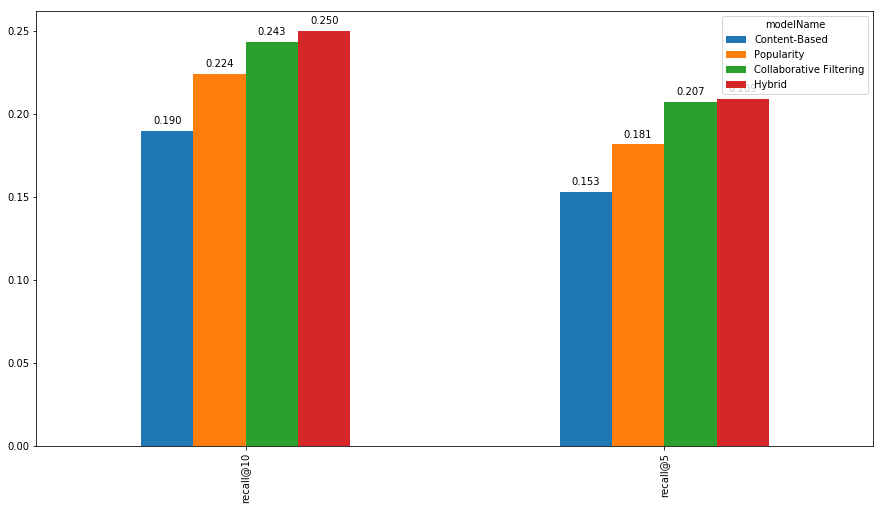

In [92]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [95]:
popularity_model.recommend_items(user_id = 'dummy', items_to_ignore=[], topn=100, verbose=False)

,contentId,eventStrength
0,5e782cd3ea7e440022515910,116.947231
1,5e95945b41a162004c575518,49.514339
2,5e959fed68c48d00292beb2a,47.994048
3,5e7ee7998735d5002991de15,46.783844
4,5e958b00bdca200024b49ecb,46.034690
5,5e05965154f7880016b75a5f,43.858499
6,5e8af4803b769d0037b551c3,41.876591
7,5e41010a1022e000161eb0ac,39.413825
8,5e8bf8a3dfb971004c66c8fd,37.468855
9,5df729fad092c70016203aae,36.030329


In [ ]:
item_popularity_df.head(10)